In [1]:
import re
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T

import monai
from monai.networks.nets.unet import UNet
from monai.losses import DiceLoss

from model import SelectionNet
from train import *


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
root_dir = "./data/malignant"
regex = re.compile(r"\d+")

def path_list_ranking(path_list):
    return sorted(path_list, key=lambda i: int(regex.findall(i)[0]))

def data_path_list(root_dir):
    path = Path(root_dir)
    all_paths = [str(image_path) for image_path in path.glob("*.png")]
    imgs_list = [img_path for img_path in all_paths if "_mask" not in img_path]
    labels_list = [label_path for label_path in all_paths if "_mask" in label_path]
    return path_list_ranking(imgs_list), path_list_ranking(labels_list)


imgs_list, labels_list = data_path_list(root_dir)
print(len(imgs_list), len(labels_list))

train_list, test_list, train_label_list, test_label_list = train_test_split(imgs_list, labels_list, test_size=110, train_size=100)

test_list[50], test_label_list[50], len(train_list)

210 210


('data\\malignant\\malignant (11).png',
 'data\\malignant\\malignant (11)_mask.png',
 100)

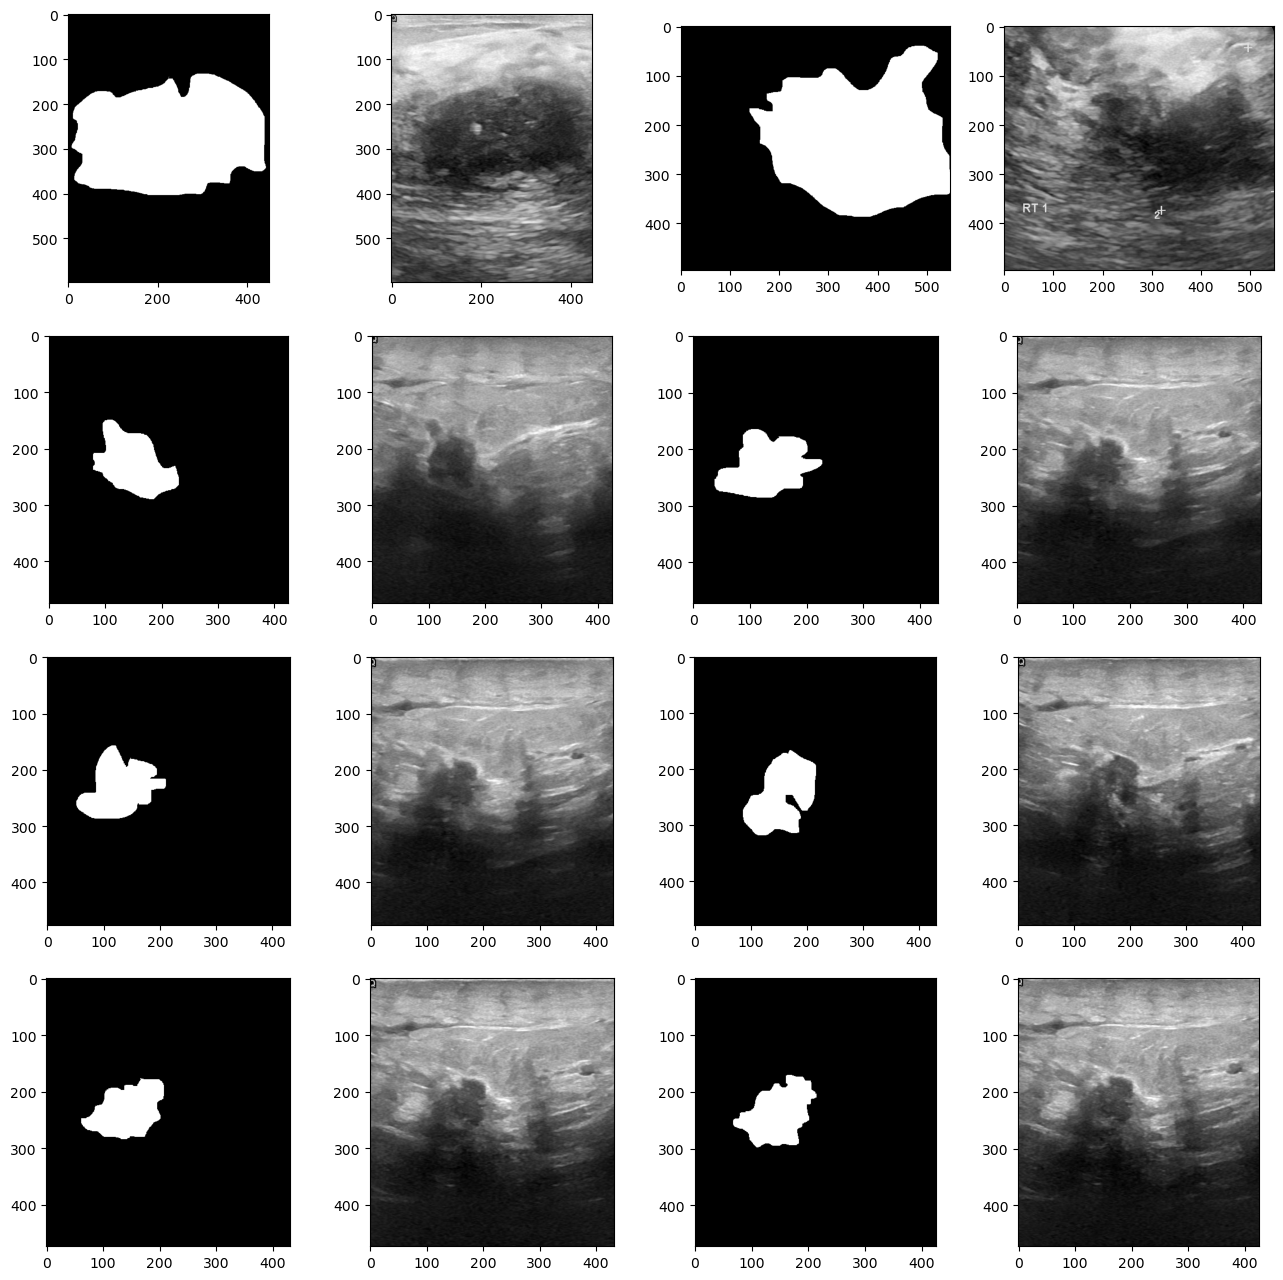

In [3]:
def plot_batch(row_col :int, img, label, figsize: tuple=(14, 14)):
    fig = plt.figure(figsize=figsize)
    for i in range(row_col * 2):
        fig.add_subplot(row_col, row_col, 2*(i+1))
        plt.imshow(plt.imread(img[i]))
        fig.add_subplot(row_col, row_col, 2*(i+1) - 1)
        plt.imshow(plt.imread(label[i]), cmap='gray')
plot_batch(4, imgs_list, labels_list, (16, 16))

In [4]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, images_list :list, 
                 labels_list :list, 
                 img_transform :T=None ,
                 label_transform :T=None):
        super().__init__()
        
        assert len(images_list) == len(labels_list) # images labels have numbers doesn't match
        self.images_list = images_list
        self.labels_list = labels_list
        self.img_transform = img_transform
        self.label_transform = label_transform
        
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, index):
        image = Image.open(self.images_list[index])
        label = Image.open(self.labels_list[index])
        
        return self.img_transform(image), self.label_transform(label)

    
    
basic_transform = T.Compose([
    T.Resize([324,324]),
#     T.Grayscale(1),
#     T.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 5)),
    T.ToTensor(),
#     T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

basic_label_transform = T.Compose([
    T.Resize([324,324]),
    T.ToTensor()
])
Seg_dataset = Dataset(train_list, train_label_list, basic_transform, basic_label_transform)
Seg_loader = DataLoader(Seg_dataset, batch_size=5, shuffle=False)

Sel_loader = DataLoader(Seg_dataset, batch_size=5, shuffle=False)

Test_dataset = Dataset(train_list, train_label_list, basic_transform, basic_label_transform)
Test_loader = DataLoader(Test_dataset, batch_size=10, shuffle=False)

In [5]:
Seg_model = UNet(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 1, 1),
    num_res_units=4,
    dropout = 0.
).to(device)

Sel_model = SelectionNet(
    DS_dim_list=[3, 32, 128, 256, 512, 1024], 
    num_resblock=1, 
    transformer_input_dim=1024, 
    num_head=8,
    dropout=0,
    num_transformer=1
).to(device)

loss_function = DiceLoss(include_background=True, to_onehot_y=False, sigmoid=True, softmax=False)
optimizer = torch.optim.Adam(Seg_model.parameters(), lr = 1e-5)
optimizer2 = torch.optim.Adam(Sel_model.parameters(), lr = 1e-5)
for b in range(100):
    loss = train_seg_net_baseon_sel_net(5, 1, 0.5, 0.5, Seg_model, Sel_model, Seg_loader, optimizer, loss_function, device)
    print(loss)
    loss = train_sel_net_baseon_seg_net(Sel_model, Seg_model, Sel_loader, optimizer2, device=device)
    print(loss)

IndexError: too many indices for tensor of dimension 4

In [ ]:
# x = torch.rand(10, 1, 24, 24)

# index = [4, 5]
# index_e = [i for i in range(10) if i not in index]
# x[index].shape, x[index_e].shape



In [ ]:
# model = SelectionNet(
#     DS_dim_list=[1, 32, 128, 256, 512, 1024], 
#     num_resblock=1, 
#     transformer_input_dim=1024, 
#     num_head=8,
#     dropout=0,
#     num_transformer=1
# ).to(device)

# x = torch.rand(5, 1, 324, 324).to(device)
# o = model(x)
# print(o.shape)
